Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [3]:
# Load preprocessed data for DNN
fetched_data = np.zeros([11307, 15104])
labels = np.zeros(11307)
data_index = 0

for actor in ACTORS:
  file_path = FILE_PATH + actor + '/'
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'

      video = []
      audio = []
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data).flatten()
      for i in range(video.shape[0]):
        fetched_data[data_index] = audio
        labels[data_index] = np.array(int(CURRENT_FILE[7])-1)
        data_index += 1

In [4]:
print(np.shape(fetched_data[-1]))

(15104,)


In [5]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.1 * example_nums)
validation_example_nums = example_nums - train_example_nums - test_example_nums

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:train_example_nums+test_example_nums]
random_validation_ids = random_ids[train_example_nums+test_example_nums:]

print(len(random_train_ids), len(random_test_ids), len(random_validation_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:])
Y_train = torch.as_tensor(labels[random_train_ids]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:])
Y_test = torch.as_tensor(labels[random_test_ids]).type(torch.int64)

X_vali = torch.as_tensor(fetched_data[random_validation_ids,:])
Y_vali = torch.as_tensor(labels[random_validation_ids]).type(torch.int64)


9045 1130 1132


In [9]:
np.shape(X_vali)

torch.Size([1132, 15104])

In [36]:
Y_vali

tensor([0, 2, 1,  ..., 4, 4, 1])

In [13]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [14]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)
validation_dataset = Dataset(X_vali, Y_vali)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([6, 6, 1,  ..., 4, 1, 2])


In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [40]:
device = get_default_device()
device

device(type='cuda')

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        out = self(features.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch
        out = self(features.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [43]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [45]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [50]:
class DNN(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(15104, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

In [52]:
model = DNN()
model.to(device)
# train_dataset.labels = train_dataset.labels.to(device)
# train_dataset.faces = train_dataset.faces.to(device)
# test_dataset.labels = test_dataset.labels.to(device)
# test_dataset.faces = test_dataset.faces.to(device)
# validation_dataset.labels = validation_dataset.labels.to(device)
# validation_dataset.faces = validation_dataset.faces.to(device)

DNN(
  (fc1): Linear(in_features=15104, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=8, bias=True)
)

In [15]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size*4)

()


In [53]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.0822300910949707, 'val_acc': 0.15583205223083496}]

In [54]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 1.7460, val_acc: 0.3432
Epoch [1], val_loss: 1.6087, val_acc: 0.4030
Epoch [2], val_loss: 1.4734, val_acc: 0.4375
Epoch [3], val_loss: 1.3635, val_acc: 0.5019
Epoch [4], val_loss: 1.3590, val_acc: 0.4711
Epoch [5], val_loss: 1.4024, val_acc: 0.4516
Epoch [6], val_loss: 1.2631, val_acc: 0.5553
Epoch [7], val_loss: 1.1399, val_acc: 0.5562
Epoch [8], val_loss: 0.9306, val_acc: 0.6895
Epoch [9], val_loss: 0.8059, val_acc: 0.7244
Epoch [10], val_loss: 0.9729, val_acc: 0.6714
Epoch [11], val_loss: 0.8143, val_acc: 0.7067
Epoch [12], val_loss: 0.8991, val_acc: 0.6727
Epoch [13], val_loss: 0.6404, val_acc: 0.7908
Epoch [14], val_loss: 0.9043, val_acc: 0.6305
Epoch [15], val_loss: 0.5421, val_acc: 0.7992
Epoch [16], val_loss: 0.6608, val_acc: 0.7546
Epoch [17], val_loss: 0.4599, val_acc: 0.8466
Epoch [18], val_loss: 0.7044, val_acc: 0.7439
Epoch [19], val_loss: 1.0463, val_acc: 0.5939


In [55]:
history += fit(20, 0.00001 , model, train_dataloader, val_dataloader)

Epoch [0], val_loss: 0.3402, val_acc: 0.9157
Epoch [1], val_loss: 0.3225, val_acc: 0.9183
Epoch [2], val_loss: 0.2928, val_acc: 0.9290
Epoch [3], val_loss: 0.3172, val_acc: 0.9086
Epoch [4], val_loss: 0.3034, val_acc: 0.9155
Epoch [5], val_loss: 0.2794, val_acc: 0.9197
Epoch [6], val_loss: 0.2581, val_acc: 0.9327
Epoch [7], val_loss: 0.2510, val_acc: 0.9367
Epoch [8], val_loss: 0.2360, val_acc: 0.9509
Epoch [9], val_loss: 0.2391, val_acc: 0.9500
Epoch [10], val_loss: 0.2385, val_acc: 0.9428
Epoch [11], val_loss: 0.2291, val_acc: 0.9433
Epoch [12], val_loss: 0.2273, val_acc: 0.9386
Epoch [13], val_loss: 0.2070, val_acc: 0.9525
Epoch [14], val_loss: 0.2009, val_acc: 0.9599
Epoch [15], val_loss: 0.2010, val_acc: 0.9603
Epoch [16], val_loss: 0.1915, val_acc: 0.9603
Epoch [17], val_loss: 0.1945, val_acc: 0.9669
Epoch [18], val_loss: 0.1918, val_acc: 0.9655
Epoch [19], val_loss: 0.1845, val_acc: 0.9573


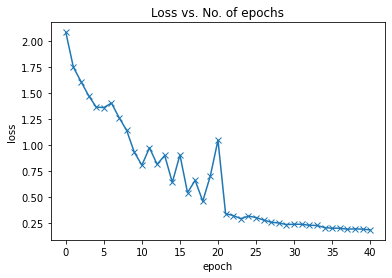

In [56]:
plot_losses(history)

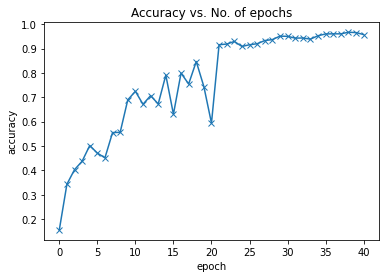

In [57]:
plot_accuracies(history)

In [58]:
evaluate(model, test_dataloader)

{'val_loss': 0.16918665170669556, 'val_acc': 0.950668215751648}

In [60]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/late_fusion_DNN/audio.pth')